# Window size importance Experiment

This notebook tests the performance of AutoPeriod as an algorithm for automatic window size selection in the context of anomaly detection.


In [9]:
from multiprocessing import Pool
import os
import random
import warnings

warnings.filterwarnings('ignore')

from automltsad.detectors import LOF, KNN, IsolationForestAD
from automltsad.metrics import precision_recall_curve, f1_pa
from automltsad.utils import (
    Autoperiod,
    sliding_window_sequences,
    to_time_series_dataset,
    reduce_window_scores,
)
from latex_figures import set_size


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update(tex_fonts)


Experiments are made only on 10 random datasets. This is a prerequisite experiment and not a part of thesis main experiments.

In [10]:
with open('data/train.txt') as f:
    datasets = f.readlines()

# indices = random.sample(range(len(datasets)),10)
# print(indices)

dataset_idx = [58, 91, 17, 90, 92, 21, 39, 79, 73, 80]
dataset_names = [datasets[i].strip('\n') for i in dataset_idx]


In [11]:
# Helper functions

def load_dataset(filename):
    """
    Load and preprocess a dataset
    """
    test_start, anomaly_start, anomaly_end = [
        int(i) for i in filename.split('.')[0].split('_')[-3:]
    ]
    ts = np.loadtxt(f'./data/datasets/{filename}')
    ts = to_time_series_dataset(ts)
    mean = np.mean(ts[:, :test_start])
    std = np.std(ts[:, :test_start])
    train = (ts[:, :test_start] - mean) / std
    test = (ts[:, test_start:] - mean) / std
    label = np.zeros_like(test)
    label[:, anomaly_start - test_start : anomaly_end - test_start] = 1
    label = np.squeeze(label)
    return train, test, label, test_start, anomaly_start, anomaly_end


def window_data(train, test, size):
    """
    Window train and test splits
    """
    train_w = sliding_window_sequences(train, size)
    test_w = sliding_window_sequences(test, size)
    return train_w, test_w


# Utility dictionaries
id_to_detector = dict(knn=KNN, lof=LOF, isoforest=IsolationForestAD)
hyperparams = {
    'knn': {},  # Default
    'lof': {},  # Default
    'isoforest': {},  # Default
}


k-NN, LOF, and IF are tested on all datasets with window sizes from 16 to 512 with steps of 16.

In [12]:
detectors = ['knn', 'lof', 'isoforest']
window_sizes = list(range(16, 513, 16))

# Create arrays for results
f1_scores = np.zeros((len(detectors), len(dataset_names), len(window_sizes)))
f1_wo_pa_scores = np.zeros(
    (len(detectors), len(dataset_names), len(window_sizes))
)
f1_pa_scores = np.zeros(
    (len(detectors), len(dataset_names), len(window_sizes))
)

# Create tasks to be processed
configurations = []
for i, det_id in enumerate(detectors):
    for j, fn in enumerate(dataset_names):
        for k, sz in enumerate(window_sizes):  # Window sizes
            configurations.append((i, j, k, det_id, fn, sz))


def process_task(config):
    """
    Preprocess data according to configuration
    Train and evaluate a detector using various metrics
    """
    i, j, k, det_id, fn, sz = config
    # Data
    train, test, label, test_start, anomaly_start, anomaly_end = load_dataset(
        fn
    )
    train_w, test_w = window_data(train, test, sz)

    # Detector
    detector = id_to_detector[det_id]
    model = detector(**hyperparams[det_id])
    model.fit(train_w)

    # Scoring
    scores = model.predict_anomaly_scores(test_w)
    scores = reduce_window_scores(scores, sz)

    # Evaluation
    p, r, t = precision_recall_curve(label, scores)
    f1 = 2 * p * r / (p + r + 1e-12)
    idx = np.nanargmax(f1)
    step = max(len(t) // 50, 1)
    f1_pas = np.asarray([f1_pa(label, scores, th) for th in t[::step]])
    f1pat = f1_pa(label, scores, t[idx])
    f1pa = np.nanmax(f1_pas)
    return i, j, k, f1[idx], f1pat, f1pa


## No need to rerun as results are already computed

# with Pool(processes=30) as pool:
#     for i,j,k,f1,f1pat,f1pa in tqdm.tqdm(pool.imap(process_task, configurations), total=len(configurations)):
#         f1_scores[i, j, k]=f1
#         f1_wo_pa_scores[i, j, k]=f1pat
#         f1_pa_scores[i, j, k]=f1pa
# np.savez('./results/window_size_experiment_results', f1_scores=f1_scores, f1_wo_pa_scores=f1_wo_pa_scores, f1_pa_scores=f1_pa_scores)

## Obtain seasonalities using AutoPeriod

# window_ap = np.zeros(len(dataset_names))
# for j, fn in enumerate(tqdm.tqdm(dataset_names)):
#     train, _, _, _, _, _ = load_dataset(fn)
#     window_ap[j] = Autoperiod(np.squeeze(train)).period
# np.save('./results/window_size_experiment_autoperiod', window_ap)


In [13]:
# Read results from previous cell
data = np.load('./results/window_size_experiment_results.npz')
f1_s, f1_wo_pa, f1_pas = (
    data['f1_scores'],
    data['f1_wo_pa_scores'],
    data['f1_pa_scores'],
)

# Load AutoPeriod seasonalities
dataset_period = np.load('./results/window_size_experiment_autoperiod.npy')


By training and evaluating the models on datasets using a range of values, a curve of performance can be plotted.

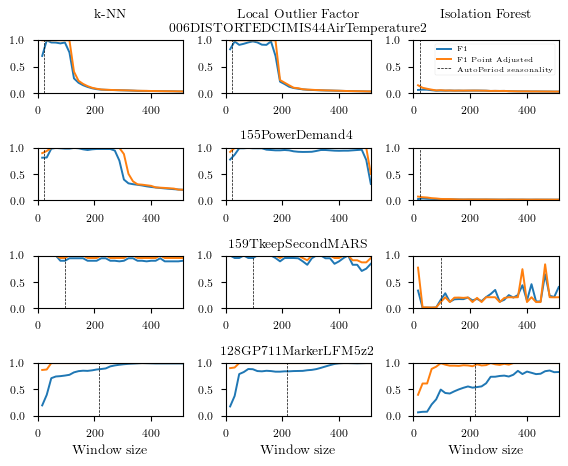

In [14]:
to_label = dict(
    knn='k-NN', lof='Local Outlier Factor', isoforest='Isolation Forest'
)

# Hand picked indexes for visualization
idxs = [0, 2, 4, 8]
dtst = [dataset_names[i] for i in idxs]

fig, axs = plt.subplots(4, 3, figsize=set_size(subplots=(4, 3)))
for i, det in enumerate(detectors):
    for j_idx, (j, fn) in enumerate(zip(idxs, dtst)):
        fn = fn.split('_')[0] + fn.split('_')[3]
        ax = axs[j_idx][i]
        ax.plot(window_sizes, f1_s[i, j], label='F1')
        ax.plot(window_sizes, f1_pas[i, j], label='F1 Point Adjusted')
        ax.axvline(
            dataset_period[j],
            ls='--',
            lw=0.5,
            color='black',
            label='AutoPeriod seasonality',
        )
        if j_idx == 3:
            ax.set_xlabel('Window size')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 512)
        if j_idx == 0:
            if i == 2:
                ax.legend(fontsize=5)
            if i == 1:
                ax.set_title(f'{to_label[det]}\n{fn}')
            else:
                ax.set_title(f'{to_label[det]}\n')

        elif i == 1:
            ax.set_title(f'{fn}')
    plt.tight_layout()

# fig.savefig('./images/window_size_f1.pdf', format='pdf', bbox_inches='tight')


From the plots, we can see that AutoPeriod seasonalties as window sizes result in to considerably good performance. One could notice that on average a better performance could be obtained if the windows were slightly larger. What would happen if the seasonalities were multiplied by some coefficient.

In [22]:
max_f1_pas = np.max(f1_pas, axis=2)
max_f1_s = np.max(f1_s, axis=2)


def evaluate(coef):
    """
    Evaluate performance of models on datasets if all AutoPeriod window sizes
    are multiplied by 'coef'.
    """
    dataset_window = dataset_period * coef
    f1_idx = [np.abs(window_sizes - n).argmin() for n in dataset_window]

    ap_f1_pas = np.zeros_like(max_f1_pas)
    ap_f1_s = np.zeros_like(max_f1_s)

    for i, idx in enumerate(f1_idx):
        ap_f1_pas[:, i] = f1_pas[:, i, idx]
        ap_f1_s[:, i] = f1_s[:, i, idx]

    ap_mean_f1_s = np.mean(ap_f1_s)
    ap_mean_f1_pas = np.mean(ap_f1_pas)
    rel1 = np.mean(ap_f1_s / max_f1_s)
    rel2 = np.mean(ap_f1_pas / max_f1_pas)

    return ap_mean_f1_s, ap_mean_f1_pas, rel1, rel2


1.5909090909090908 0.48021128849647904


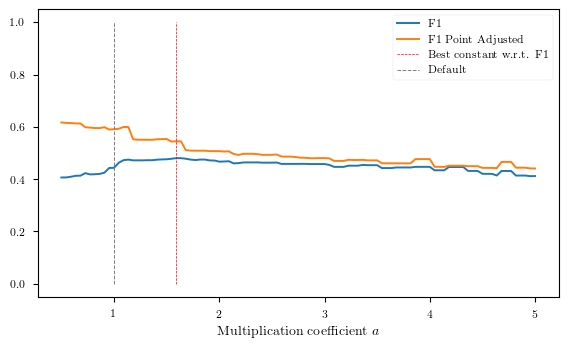

In [23]:
coefs = np.linspace(0.5, 5, 100)
cs = []
f1s = []
f1pas = []

# Evaluate on coefs
for c in coefs:
    ap_mean_f1_s, ap_mean_f1_pas, _, _ = evaluate(c)
    cs.append(c)
    f1s.append(ap_mean_f1_s)
    f1pas.append(ap_mean_f1_pas)

idx = np.nanargmax(f1s)
best_c = cs[idx]
best_f1 = f1s[idx]
print(best_c, best_f1)

fig, axs = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
axs.plot(cs, f1s, label='F1')
axs.plot(cs, f1pas, label='F1 Point Adjusted')
axs.set_xlabel('Multiplication coefficient $a$')
axs.vlines(
    best_c,
    0,
    1,
    linestyles='--',
    color='red',
    linewidth=0.5,
    label='Best constant w.r.t. F1',
)
axs.vlines(
    1, 0, 1, linestyles='--', color='grey', linewidth=0.7, label='Default'
)
axs.legend()
plt.tight_layout()

# fig.savefig('./images/window_size_f1_a.pdf', format='pdf', bbox_inches='tight')


In [28]:
for size in [16.0, 32.0, 64.0, 128.0]:
    dataset_window = np.array([size] * 10)
    f1_idx = [np.abs(window_sizes - n).argmin() for n in dataset_window]

    ap_f1_pas = np.zeros_like(max_f1_pas)
    ap_f1_s = np.zeros_like(max_f1_s)

    for i, idx in enumerate(f1_idx):
        ap_f1_pas[:, i] = f1_pas[:, i, idx]
        ap_f1_s[:, i] = f1_s[:, i, idx]

    ap_mean_f1_s = np.mean(ap_f1_s)
    ap_mean_f1_pas = np.mean(ap_f1_pas)
    rel1 = np.mean(ap_f1_s / max_f1_s)
    rel2 = np.mean(ap_f1_pas / max_f1_pas)

    print(f'Window size: {size}')
    print(f'Mean F1: {np.mean(ap_f1_s)}')
    print(f'Mean F1 of [k-NN, LOF, IF] = {np.mean(ap_f1_s, axis=1)}')


Window size: 16.0
Mean F1: 0.34234452381740993
Mean F1 of [k-NN, LOF, IF] = [0.46578643 0.46680993 0.09443721]
Window size: 32.0
Mean F1: 0.40297529912163044
Mean F1 of [k-NN, LOF, IF] = [0.58106028 0.5780393  0.04982631]
Window size: 64.0
Mean F1: 0.43488155633258224
Mean F1 of [k-NN, LOF, IF] = [0.61172047 0.63631079 0.0566134 ]
Window size: 128.0
Mean F1: 0.3876786560418222
Mean F1 of [k-NN, LOF, IF] = [0.49990792 0.59007066 0.07305738]


In [20]:
print(f'Mean dataset period: {np.mean(dataset_period)}')


Mean dataset period: 68.7


Default performance of models with coef of 1

In [25]:
dataset_window = dataset_period * 1
f1_idx = [np.abs(window_sizes - n).argmin() for n in dataset_window]

ap_f1_pas = np.zeros_like(max_f1_pas)
ap_f1_s = np.zeros_like(max_f1_s)

for i, idx in enumerate(f1_idx):
    ap_f1_pas[:, i] = f1_pas[:, i, idx]
    ap_f1_s[:, i] = f1_s[:, i, idx]

ap_mean_f1_s = np.mean(ap_f1_s)
ap_mean_f1_pas = np.mean(ap_f1_pas)
rel1 = np.mean(ap_f1_s / max_f1_s)
rel2 = np.mean(ap_f1_pas / max_f1_pas)

print(f'Mean F1: {np.mean(ap_f1_s)}')
print(f'Mean F1 of [k-NN, LOF, IF] = {np.mean(ap_f1_s, axis=1)}')


Mean F1: 0.4432790054648529
Mean F1 of [k-NN, LOF, IF] = [0.60218695 0.61888692 0.10876315]


Performance of models with best coefficient

In [26]:
dataset_window = dataset_period * 1.59
f1_idx = [np.abs(window_sizes - n).argmin() for n in dataset_window]

ap_f1_pas = np.zeros_like(max_f1_pas)
ap_f1_s = np.zeros_like(max_f1_s)

for i, idx in enumerate(f1_idx):
    ap_f1_pas[:, i] = f1_pas[:, i, idx]
    ap_f1_s[:, i] = f1_s[:, i, idx]

ap_mean_f1_s = np.mean(ap_f1_s)
ap_mean_f1_pas = np.mean(ap_f1_pas)
rel1 = np.mean(ap_f1_s / max_f1_s)
rel2 = np.mean(ap_f1_pas / max_f1_pas)

print(f'Mean F1: {np.mean(ap_f1_s)}')
print(f'Mean F1 of [k-NN, LOF, IF] = {np.mean(ap_f1_s, axis=1)}')


Mean F1: 0.48021128849647904
Mean F1 of [k-NN, LOF, IF] = [0.65035861 0.66434194 0.12593332]


Maximum performance of models

In [27]:
print(f'Mean F1: {np.mean(max_f1_s)}')
print(f'Mean F1 of [k-NN, LOF, IF] = {np.mean(max_f1_s, axis=1)}')


Mean F1: 0.5381219312171103
Mean F1 of [k-NN, LOF, IF] = [0.69782094 0.69961553 0.21692933]


### Compute periods for the rest of the datasets

In [11]:
# UCR Datasets

with open('data/train.txt') as f:
    train = f.readlines()

with open('data/test.txt') as f:
    test = f.readlines()

files = train + test


def task(file):
    start, a_start, a_end = [
        int(i) for i in file.split('.')[0].split('_')[-3:]
    ]
    file = file.strip('\n')
    ts = np.loadtxt(f'./data/datasets/{file}')
    traints = ts[:start]
    train_period = Autoperiod(traints).period
    train_period = train_period if train_period else 32
    train_period = train_period if train_period < 512 else 512
    train_period = train_period if train_period > 8 else 8
    period = Autoperiod(ts).period
    return file, train_period, period


# No need to run again

# periods = []
# with Pool(processes=40) as pool:
#     results = list(tqdm.tqdm(pool.imap(task, files), total=len(files)))

# with open('./data/period.txt','w') as f:
#     for r in results:
#         f.write(f'{r[0]}, {r[1]}, {r[2]}\n')


In [2]:
# NAB Datasets

path = './data/datasets/numenta'
files = [
    f
    for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f)) and f.endswith('.csv')
]


def task(f):
    ts = pd.read_csv(f'./data/datasets/numenta/{f}')['value'].values
    ts = ts[: len(ts) // 2]
    train_period = Autoperiod(ts).period
    train_period = train_period if train_period else 32
    train_period = train_period if train_period < 512 else 512
    train_period = train_period if train_period > 8 else 8
    return f, train_period


# No need to rerun

# periods = []

# with Pool(processes=30) as pool:
#     results = list(tqdm.tqdm(pool.imap(task, files), total=len(files)))

# with open('./data/numenta_period.txt', 'w') as f:
#     for r in results:
#         f.write(f'{r[0]}, {r[1]}\n')


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


The computed seasonalities are used as window sizes for all other experiments.